In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

Чтение и беглое исследование данных

In [2]:
data = pd.read_csv('./Data/winequality-red.csv', delimiter=';')
data.head()ча

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
# На всякий случай посмотрим хотя бы на наличие пропусков и грубых отклонений
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


<Axes: >

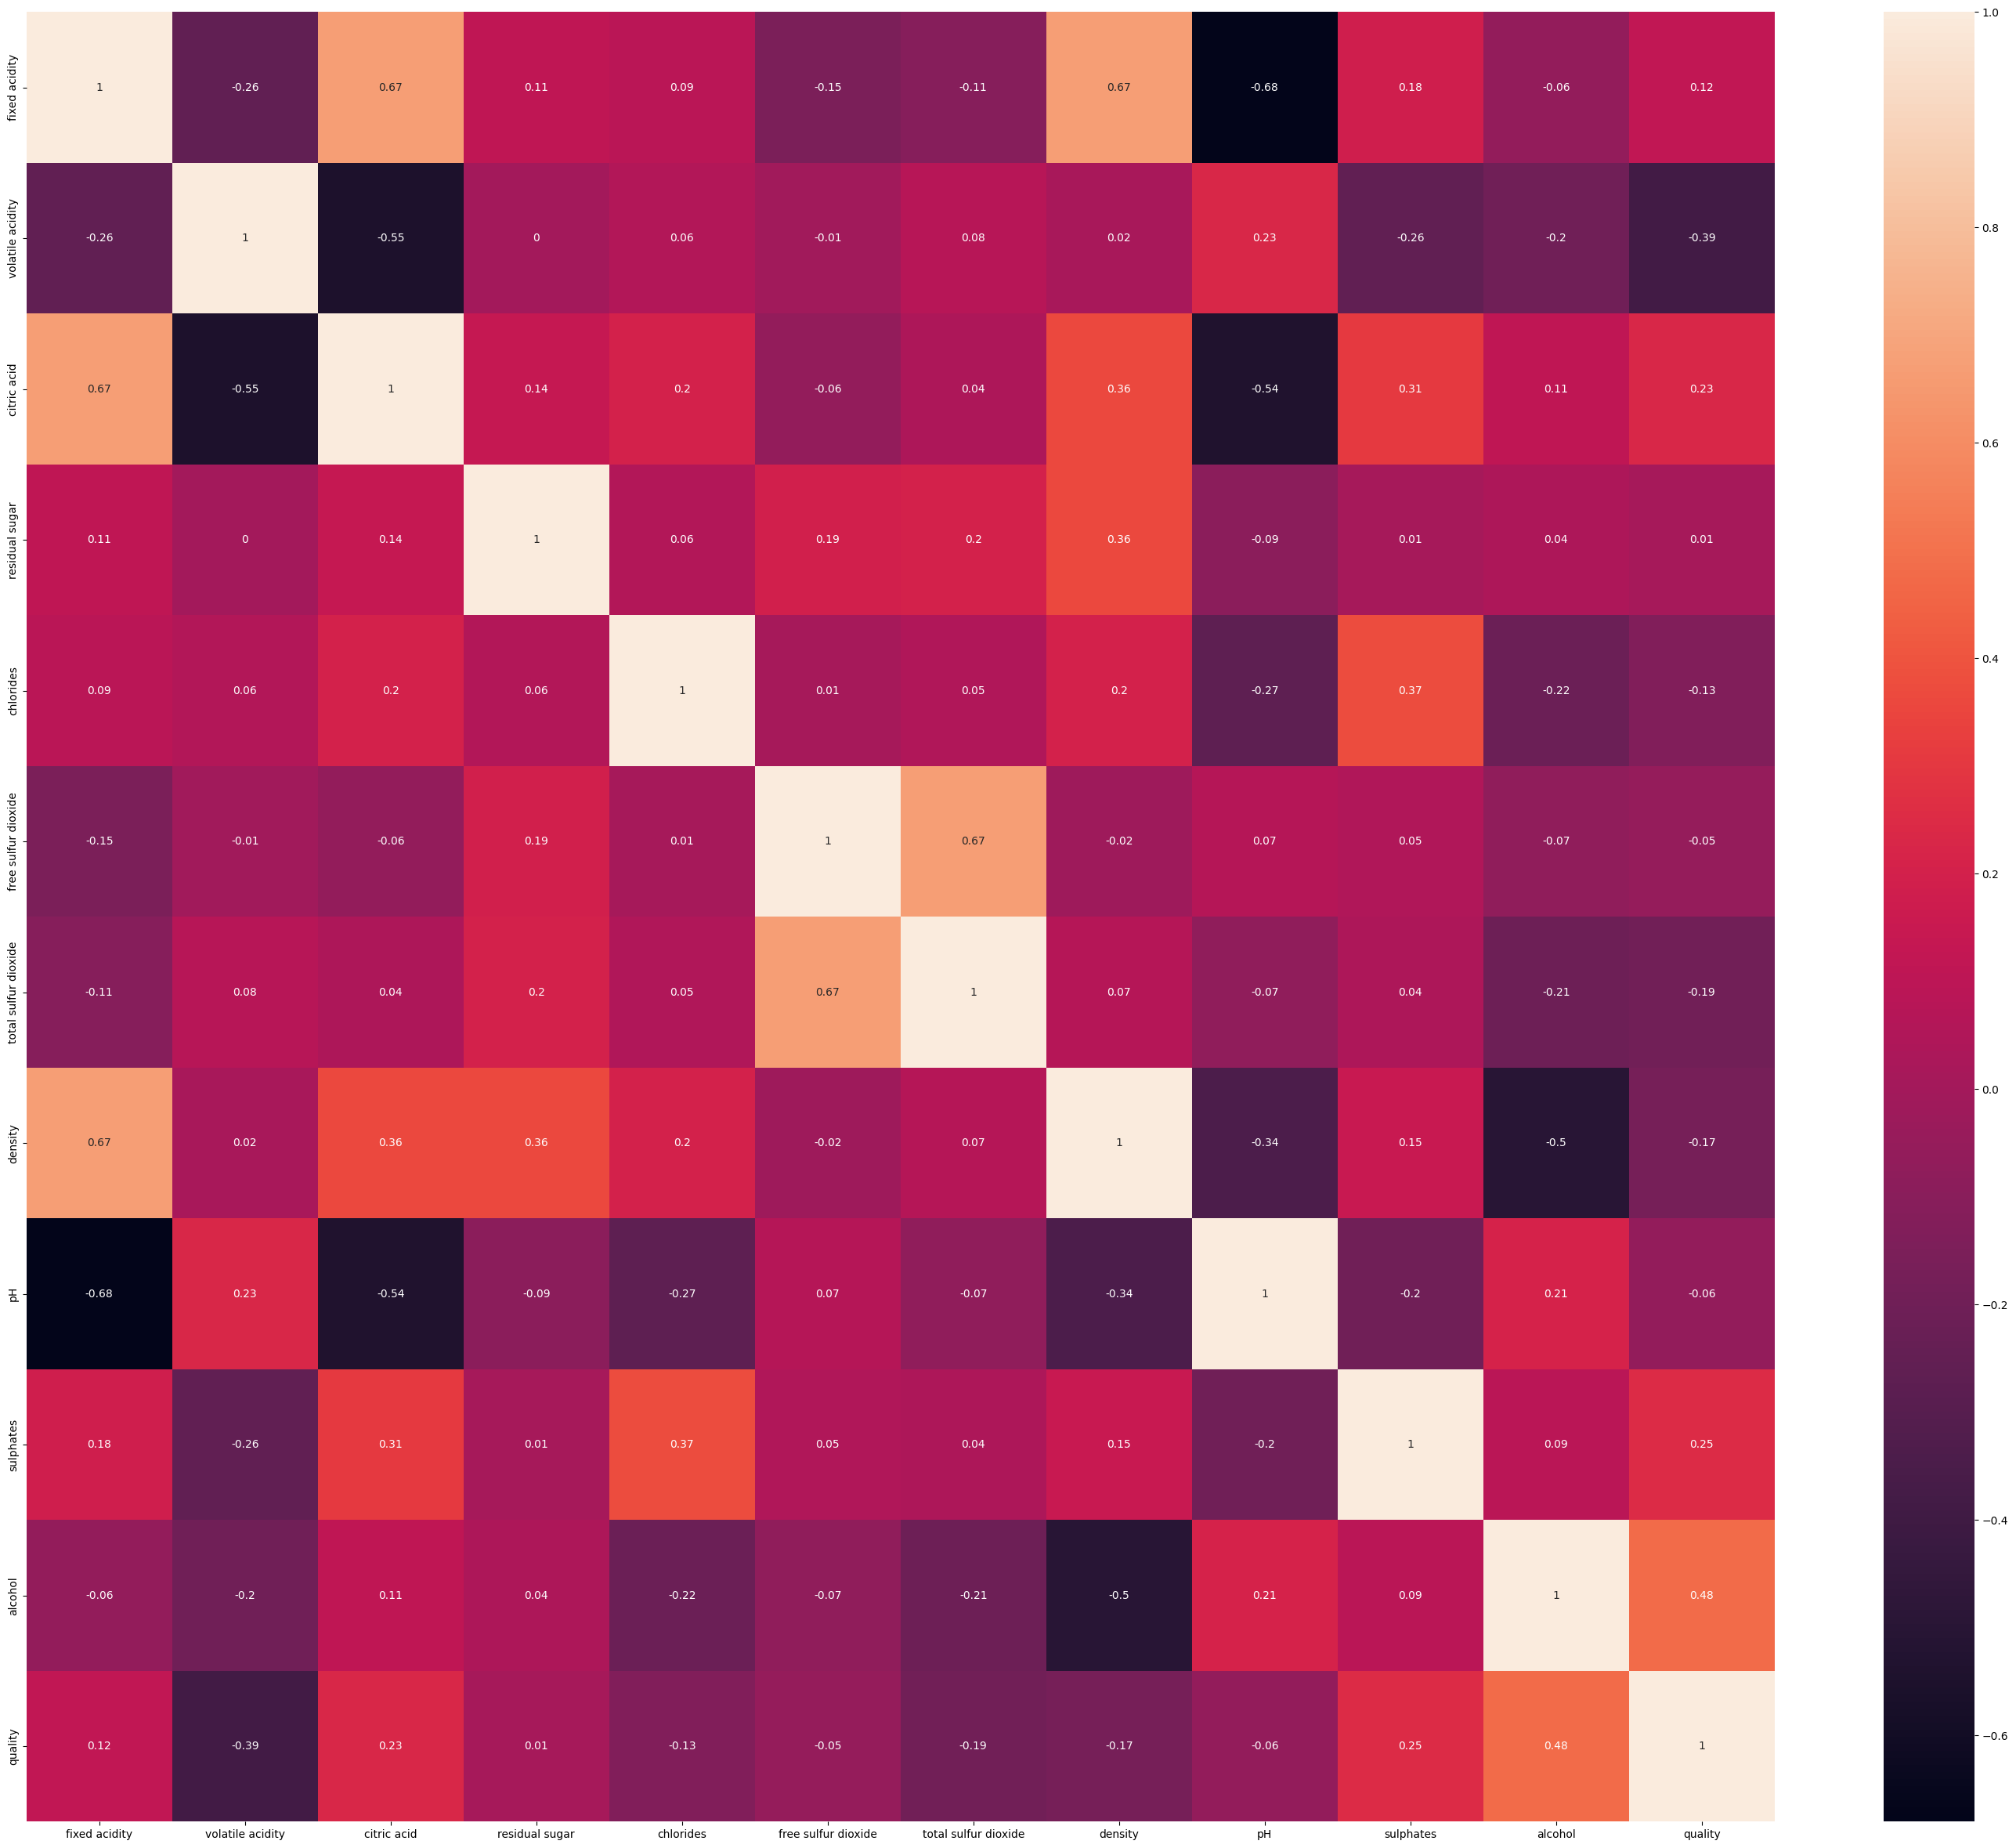

In [4]:
fig = plt.figure(figsize=(36, 30))
sns.heatmap(round(data.corr(), 2), annot=True)

Наблюдается только слабая связь (+/-0.3 - +/-0.5) целевой переменной с количеством алкоголя (положительная) и летучей кислотностью (отрицательная).<br/>
Также на границе средней и сильной связи находятся несколько признаков, например fixed acidity - pH.

Попытки исключить признак pH или отмасштабировать пришнаки не дали положительного эффекта, поэтому просто разделим данные на факторы и целевую переменную.

In [5]:
#scaler = StandardScaler()
#X = scaler.fit_transform(data.drop(columns=['quality', 'pH']))
#X = pd.DataFrame(X, columns=scaler.get_feature_names_out())

#X = data.drop(columns=['quality', 'pH'], axis = 1)
X = data.drop(columns=['quality'], axis = 1)
y = data['quality']

Создадим генератор для демонстрации возможности дообучения модели и передачи метрик в Prometheus

In [6]:
def streaming_reading(X_train, y_train, batch_size=500):
    X = []
    y = []
    current_line = 0
    train_data, train_label = shuffle(X_train, y_train, random_state=0)
    train_data = train_data.to_numpy()
    for row, target in zip(train_data, train_label):
        X.append(row)
        y.append(target)

        current_line += 1
        if current_line >= batch_size:
            X, y = np.array(X), np.array(y)
            yield X, y
            X, y = [], []
            current_line = 0

In [7]:
# Для демонстрации готовим списки под метрики
rmse_list = []
mape_list = []

Используем lightgbm в режиме дообучения для задачи регрессии с метриками mape и rmse

In [8]:
# исходная модель перенесена в параметры для возможности дообучения
def IncrementaLightGbm(X, y, gbm = None):  

    params = {
        'task': 'train',
        'application': 'regression',  
        'boosting_type': 'gbdt', 
        'learning_rate': 0.05,  
        'tree_learner': 'serial',
        'metric': ['mape', 'rmse'], 
        #'max_bin': 255,
        'feature_fraction': 0.9,
        'num_leaves': 31,
        'verbose': -1
    }
    streaming_train_iterators = streaming_reading(X, y, batch_size=300) # в реальности заменить на чтение новых данных

    for i, data in enumerate(streaming_train_iterators):
        X_batch = data[0]
        y_batch = data[1]
        X_train, X_test, y_train, y_test = train_test_split(X_batch, y_batch, test_size=0.1, random_state=0)
        y_train = y_train.ravel()
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

        gbm = lgb.train(params,
                        lgb_train,
                        num_boost_round=1000,
                        valid_sets=lgb_eval,
                        init_model=gbm, # для дообучения
                        #early_stopping_rounds=10,
                        #verbose_eval=False,
                        keep_training_booster=True) # для дообучения

        print("{} time".format(i))  
        score_train = dict([(score[1], score[2]) for score in gbm.eval_train()])
        print('The score of the current model in the training set is: rmse=%.4f, mape=%.4f, \n'
             % (score_train['rmse'], score_train['mape']))
        
        rmse_list.append(score_train['rmse'])
        mape_list.append(score_train['mape'])

    return gbm

In [9]:
# для реального дообучения нужно прочитать текущую модель и вызвать функционал обучения на новых данных с инициализацией текущей моделью

#gbm = joblib.load('regr_wine_model.pkl')
gbm = None

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state=42)
gbm = IncrementaLightGbm(train_X, train_y, gbm)
pred_y = gbm.predict(test_X)
#print(f'rmse: {np.sqrt(mean_squared_error(test_y, pred_y))}')
#print('------------------------------------------')
#print(f'mape: {mean_absolute_percentage_error(test_y, pred_y)}')

#joblib.dump(gbm, 'regr_wine_model.pkl')

0 time
The score of the current model in the training set is: rmse=0.0323, mape=0.0041, 

1 time
The score of the current model in the training set is: rmse=0.0376, mape=0.0050, 

2 time
The score of the current model in the training set is: rmse=0.0270, mape=0.0036, 

3 time
The score of the current model in the training set is: rmse=0.0221, mape=0.0028, 



In [10]:
mape_list

[0.004136916377146934,
 0.004964238684927212,
 0.0035574259990855334,
 0.002841849074289498]

 Публикуем метрики (экспортируем в Prometheus)

In [11]:
from prometheus_client import start_http_server, Gauge
import time
import numpy as np

WINE_RMSE = Gauge('WINE_RMSE', 'RMSE metric')
WINE_MAPE = Gauge('WINE_MAPE', 'MAPE metric')

In [12]:
def set_metrics():
    if len(rmse_list) > 0:
        WINE_RMSE.set(rmse_list.pop(0))
    if len(rmse_list) > 0:
        WINE_MAPE.set(mape_list.pop(0))

In [13]:
if __name__ == '__main__':
    # Start up the server to expose the metrics.
    start_http_server(9091)
    print("Exporter running at http://localhost:9091")

    # Call the set_gc_incidents_metrics every 30 seconds, indefintely
    while True:
        set_metrics()
        time.sleep(30)

Exporter running at http://localhost:9091


Итак, в Prometheus настроено получение данных с нашего web-сервера

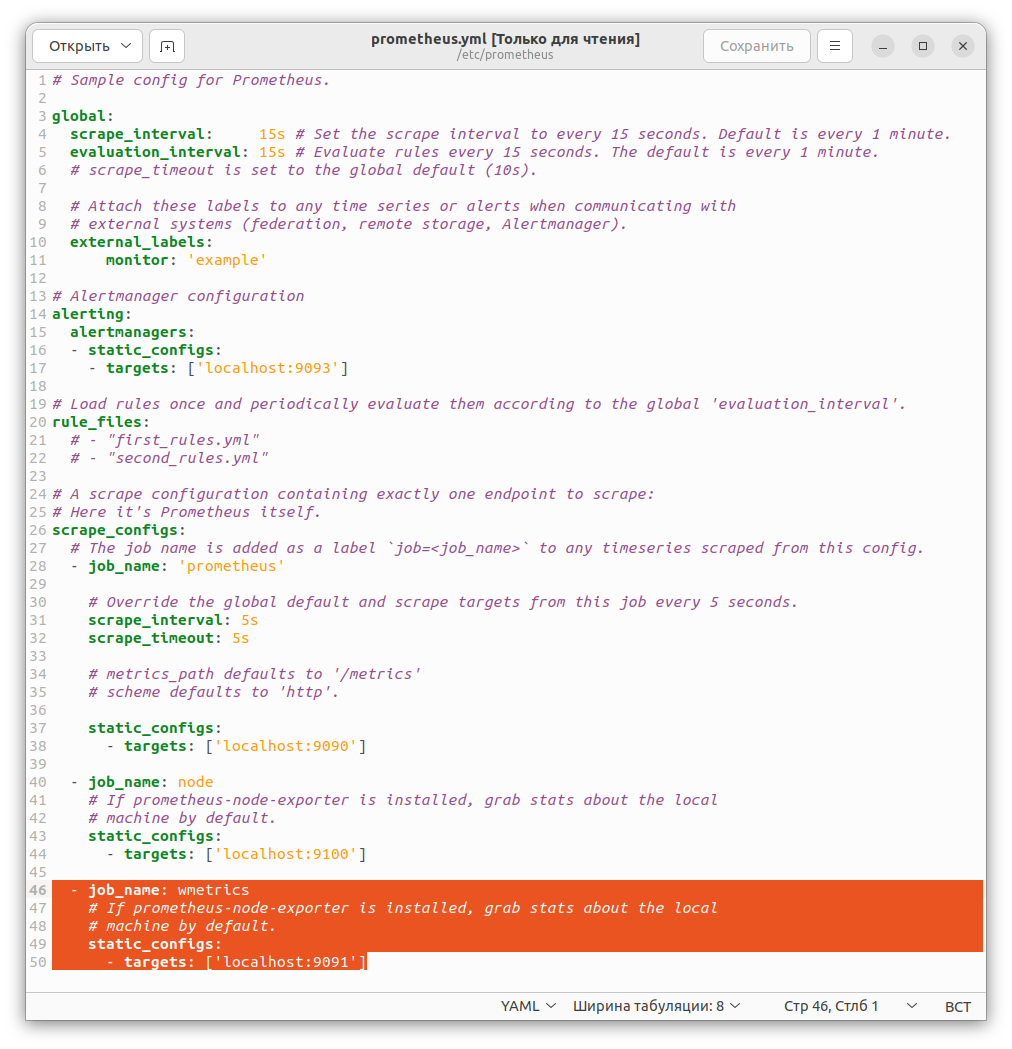

Метрики в Prometheus

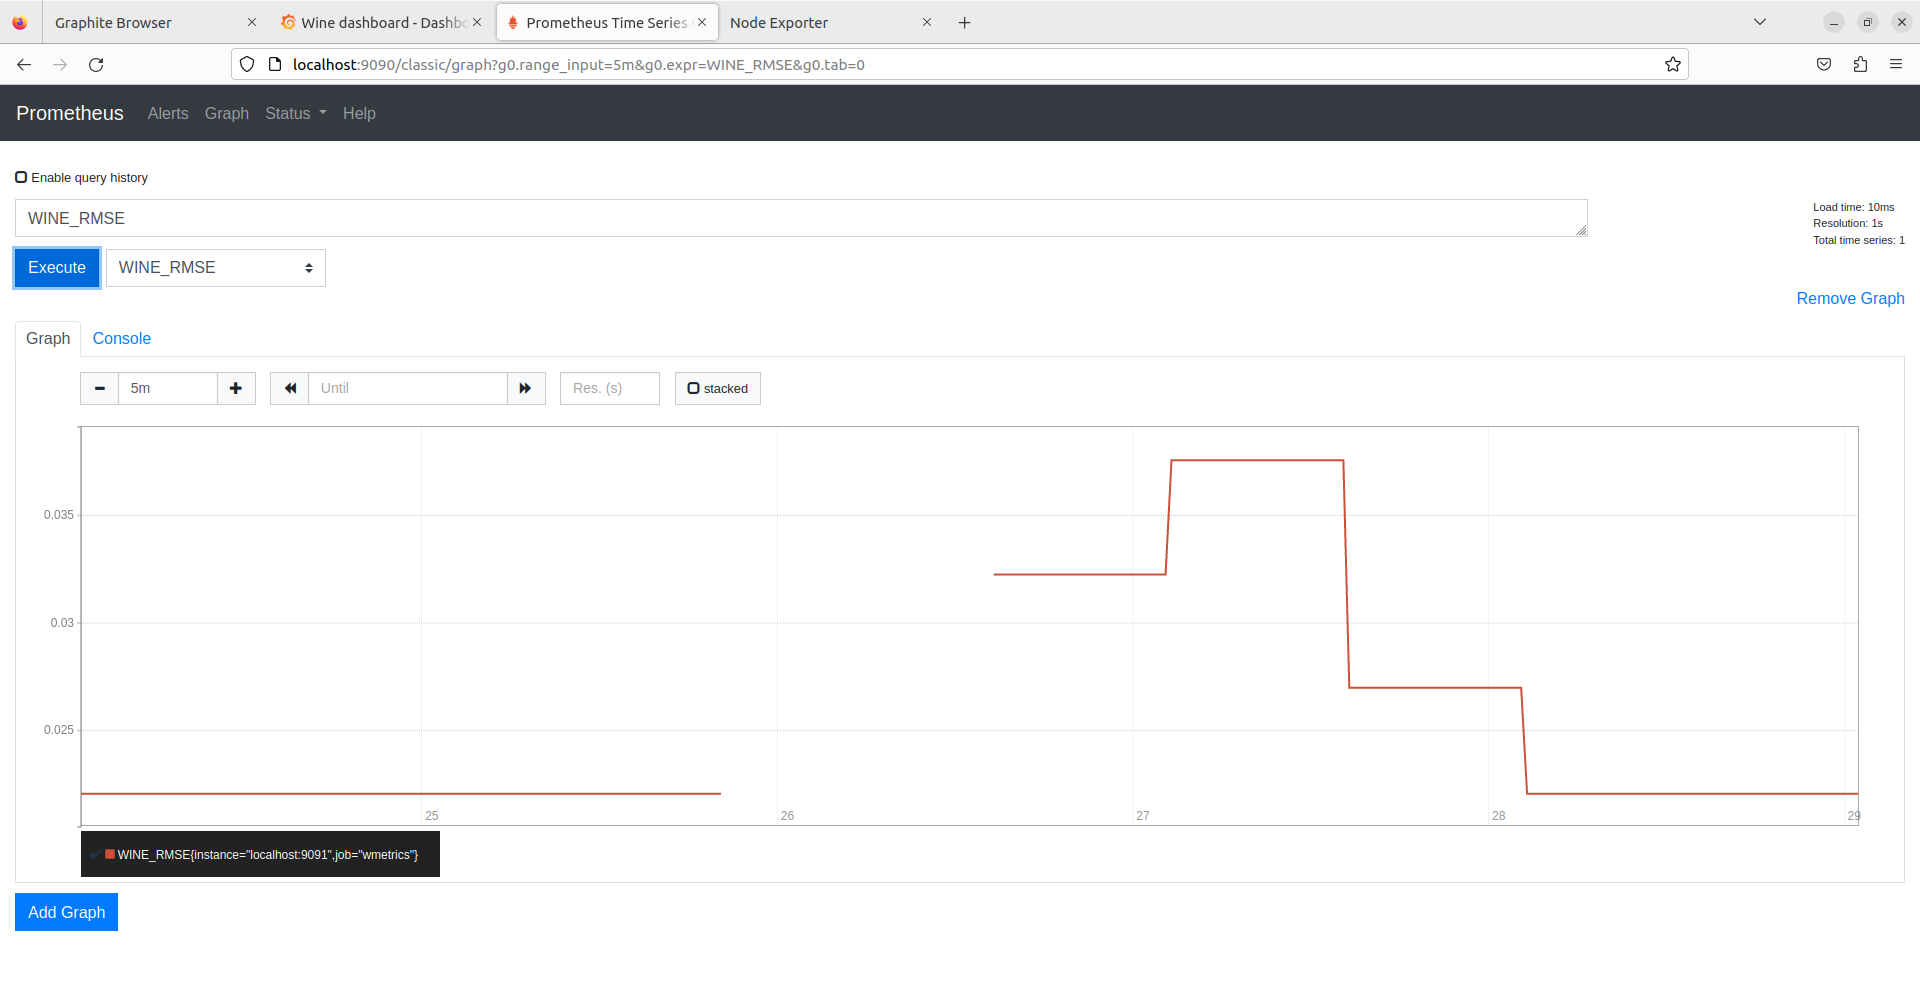

Дашборд метрик в Grafana

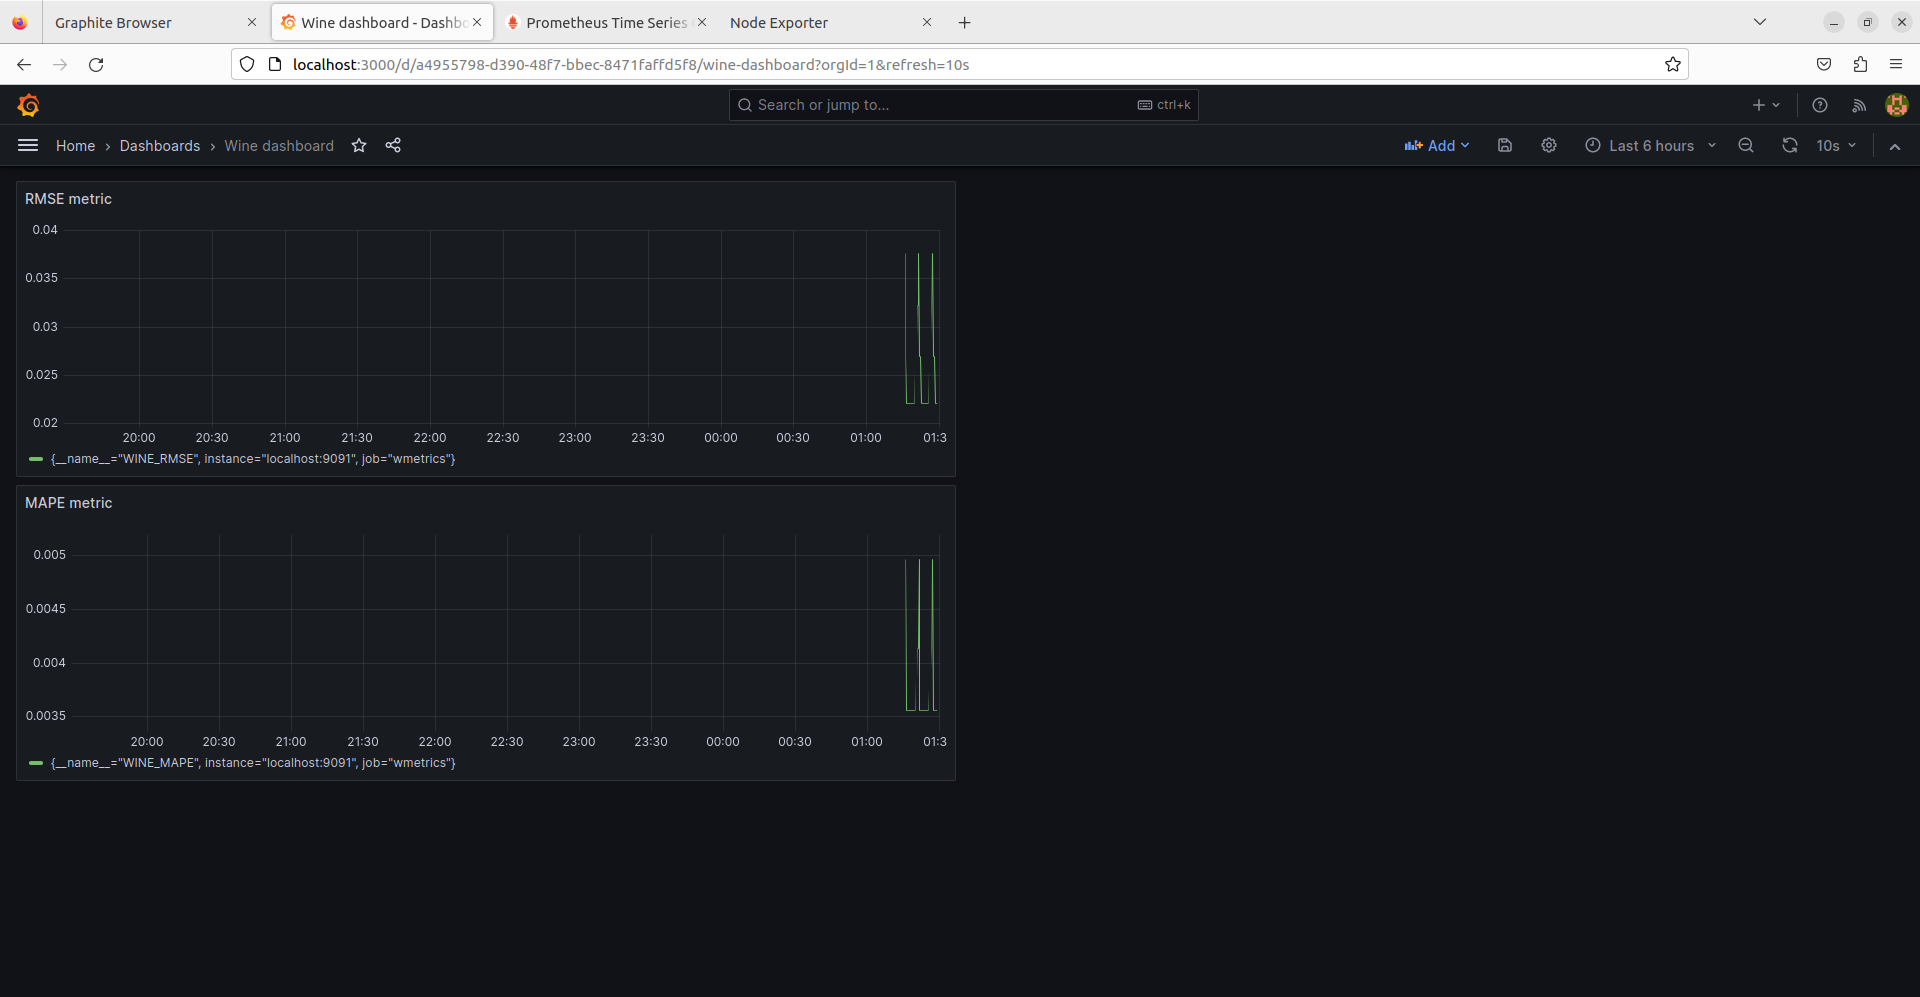